In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.2 MB/s eta 0:00:00


In [ ]:
!pip install scikit-image -U

In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
from pydicom.filereader import dcmread
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndimage
from skimage import measure

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Some constants
INPUT_FOLDER = '/content/drive/My Drive/stage1'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(len(patients))
#patients.remove('.DS_Store')

4


In [ ]:
# Load the scans in given folder path
def load_scan(path):
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dcmread((path + '/' + s),force = True) for s in ds]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [ ]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)

    return np.array(image, dtype=np.int16)

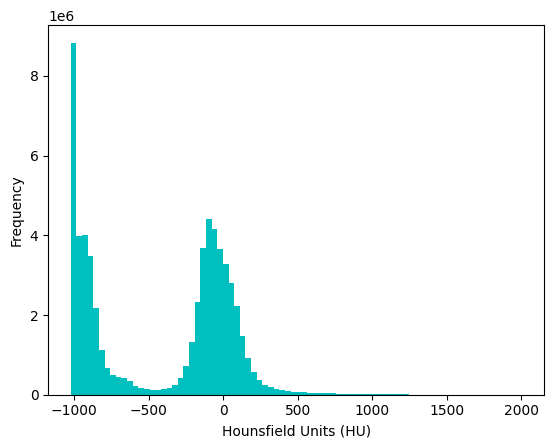

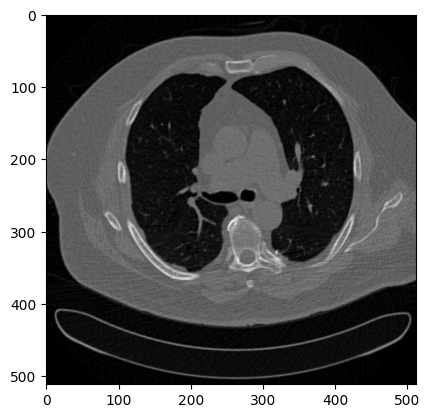

(0.0, 1.0, 0.0, 1.0)

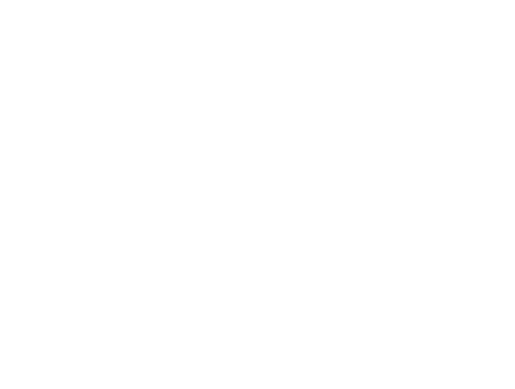

In [ ]:
first_patient = load_scan(INPUT_FOLDER +'/'+ patients[2])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()
plt.axis('off')

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)

    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

<ipython-input-9-3563f2277ec2>:12: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)


Shape before resampling	 (233, 512, 512)
Shape after resampling	 (350, 414, 414)


In [ ]:
def plot_3d(image, threshold=-300):

    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]

    try:
         verts, faces,_,_ = measure.marching_cubes_lewiner(p, threshold)

    except AttributeError:
         verts, faces,_,_ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    return plt.show()

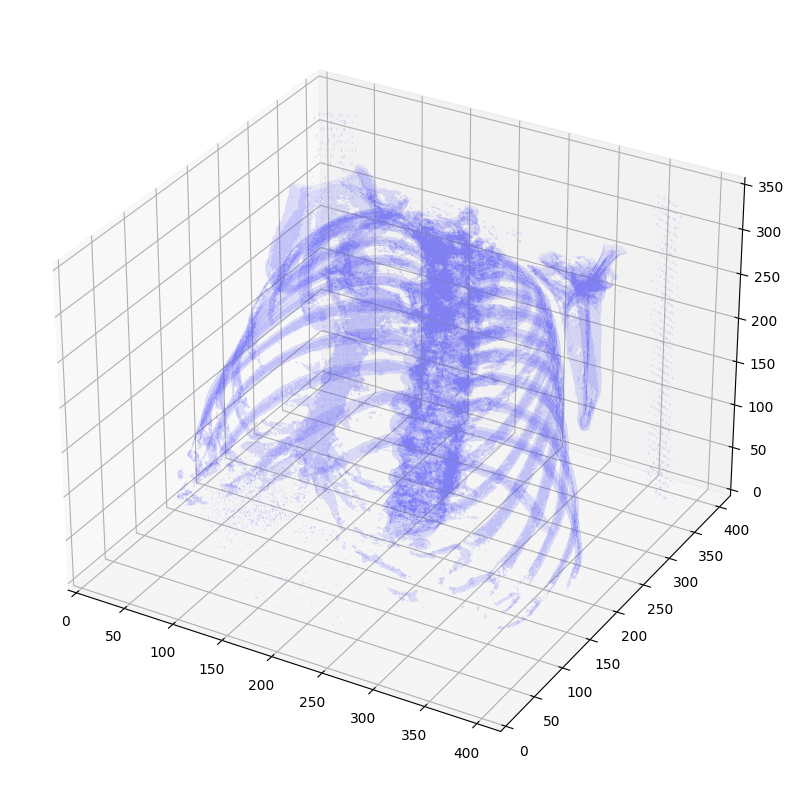

In [ ]:
plot_3d(pix_resampled, 400)

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest

def segment_lung_mask(image, fill_lung_structures=True):

    # not actually binary, but 1 and 2.
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -350, dtype=np.int8)+1
    labels = measure.label(binary_image)

    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air
    #   around the person in half
    background_label = labels[0,0,0]

    #Fill the air around the person
    binary_image[background_label == labels] = 2




    # Method of filling the lung structures (that is superior to something like
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)

            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1


    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1

    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

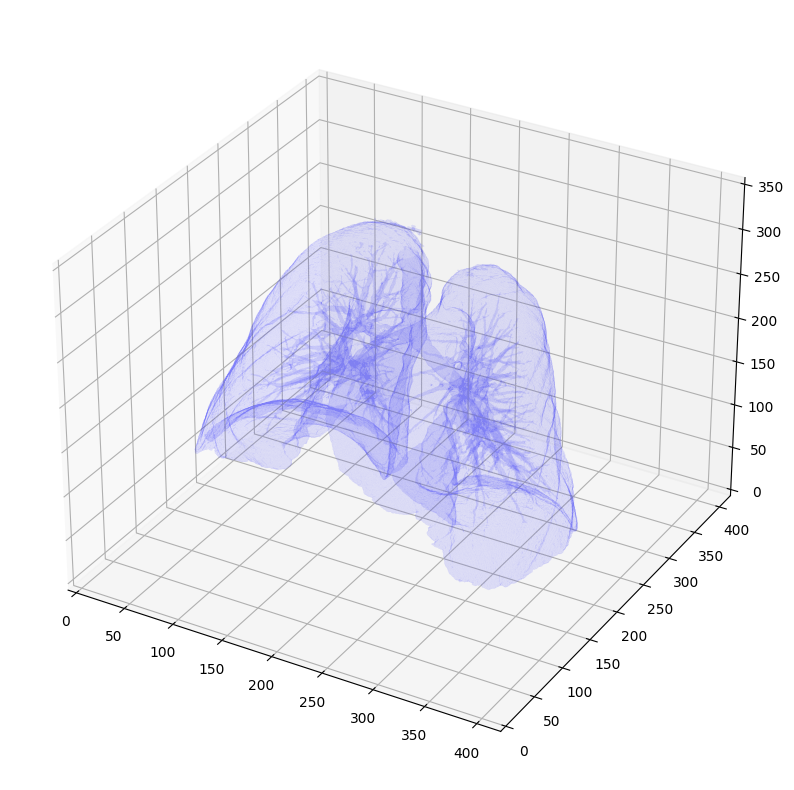

In [ ]:
plot_3d(segmented_lungs, 0)

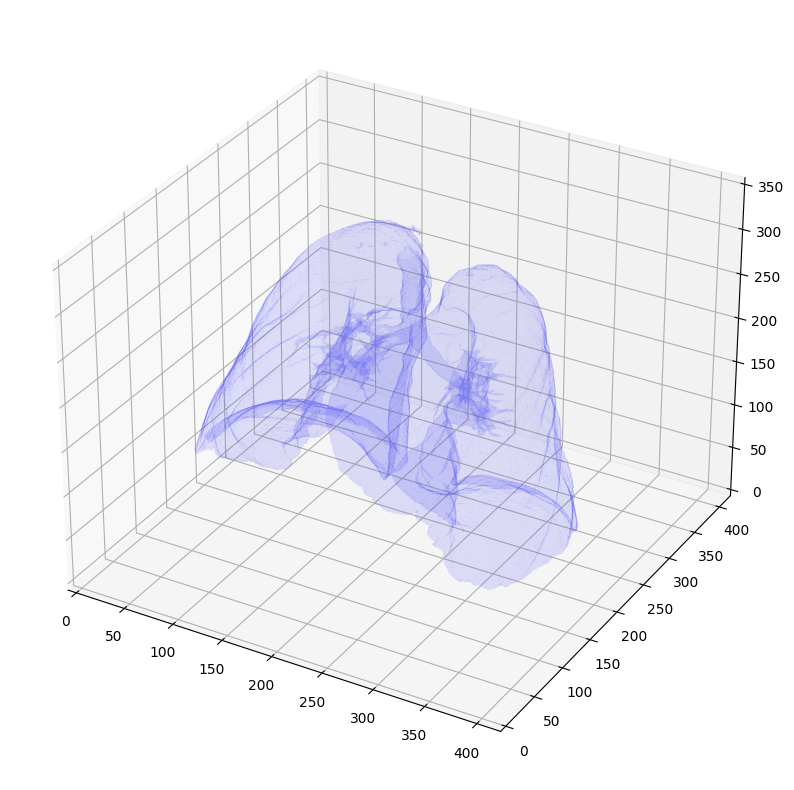

In [ ]:
plot_3d(segmented_lungs_fill, 0)

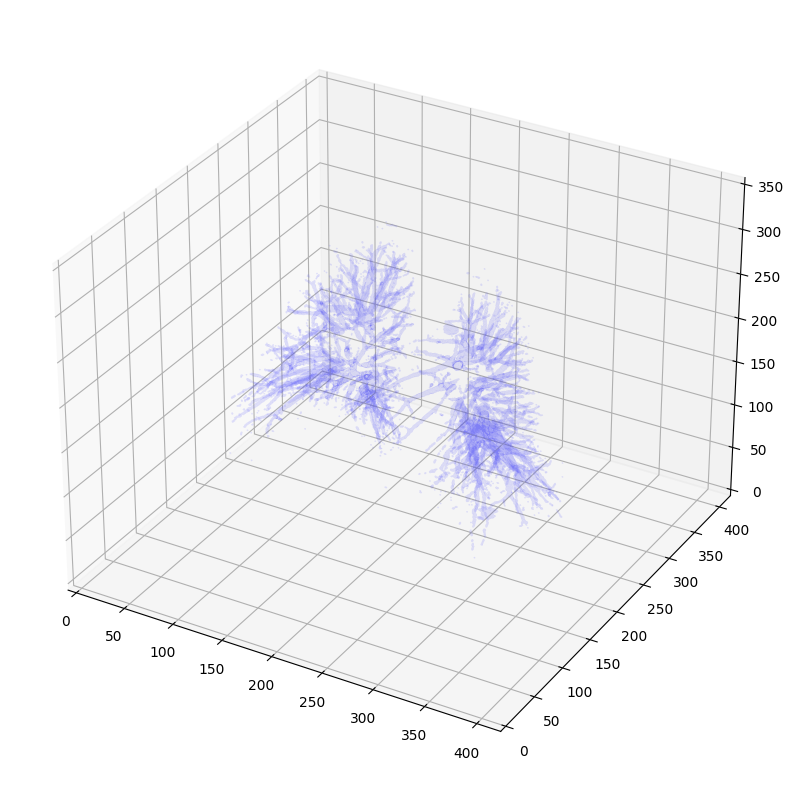

In [ ]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

# **Watershed Algorithm**

In [ ]:
test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[1])
test_patient_images = get_pixels_hu(test_patient_scans)

Original Slice


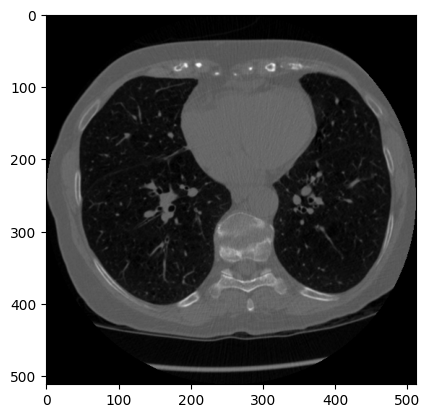

In [ ]:
print ("Original Slice")
plt.imshow(test_patient_images[100], cmap='gray')
plt.show()

Internal Marker


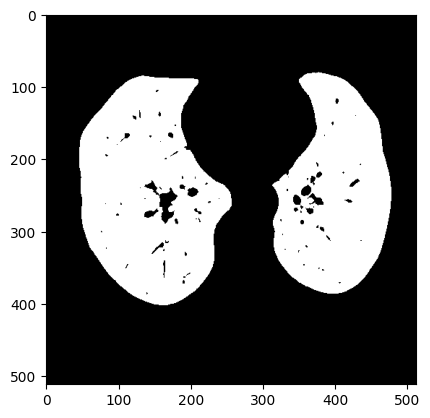

External Marker


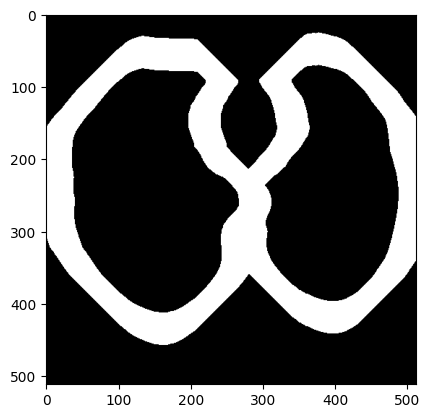

Watershed Marker


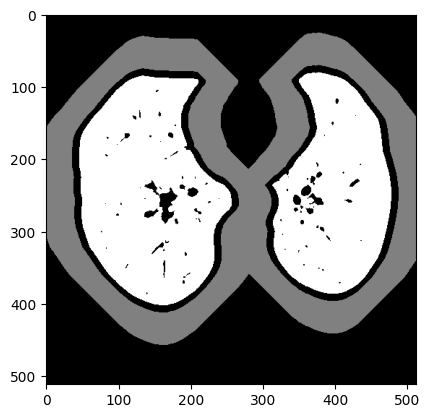

In [ ]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128

    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[100])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

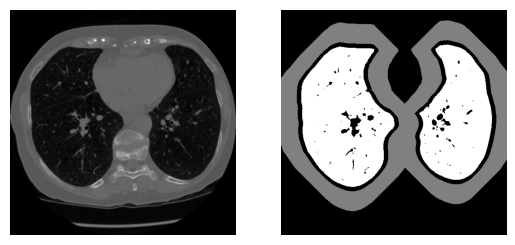

In [ ]:
plt.subplot(121)
plt.imshow(test_patient_images[100],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_patient_watershed,cmap = 'gray')
plt.axis('off')

<ipython-input-22-8fcf1dbe62bc>:36: DeprecationWarning: Please import `binary_closing` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)


Lung Nodule


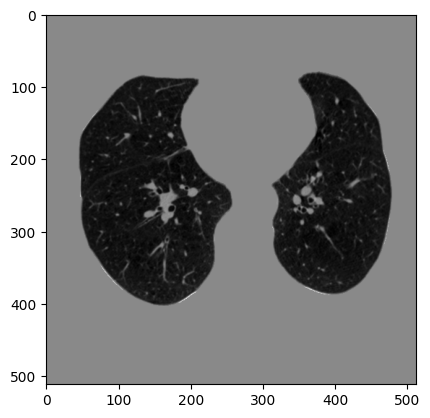

Sobel Gradient


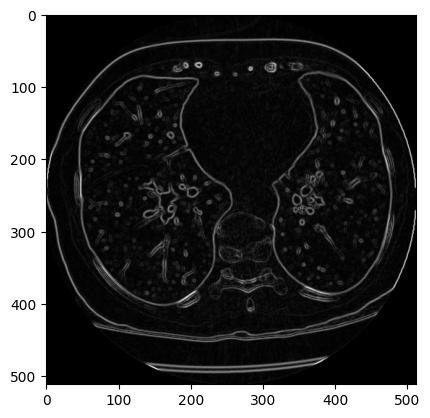

Watershed Image


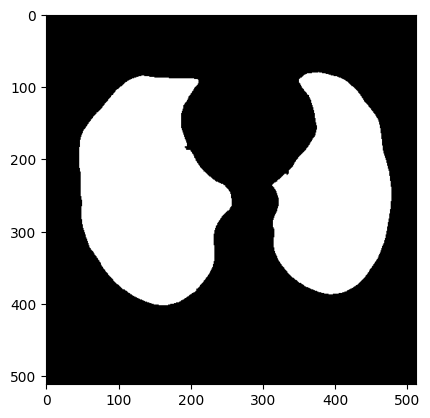

Outline after reinclusion


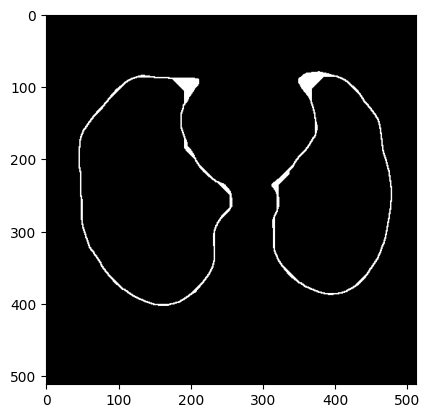

Lungfilter after closing


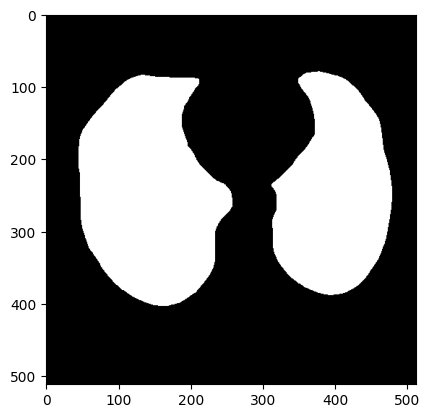

Segmented Lung


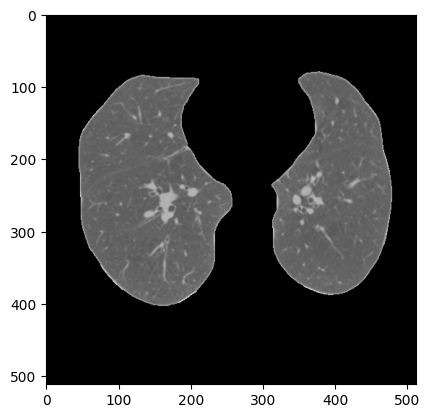

In [ ]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)

    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)

    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)

    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)

    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]

    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)

    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)

    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))


    return segmented, lung_nodule, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, lung_nodule, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[100])

print ("Lung Nodule")
plt.imshow(lung_nodule, cmap='gray')
plt.show()
print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

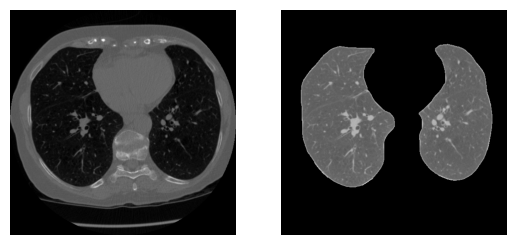

In [ ]:
plt.subplot(121)
plt.imshow(test_patient_images[100],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_segmented,cmap = 'gray')
plt.axis('off')

In [ ]:
test_segmented.shape

(512, 512)

# **Preparation For Classifier**

In [ ]:
labels_df = pd.read_csv('/content/drive/My Drive/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [ ]:


# Assuming your patient data is located in a folder named "stage1"
# under "/content/drive/My Drive/"
INPUT_FOLDER = '/content/drive/My Drive/stage1'  # Changed to the correct path

labels_df = pd.read_csv('/content/drive/My Drive/stage1_labels.csv', index_col=0)

for patient in patients[:1]:
    label = labels_df.at[(patient, 'cancer')]
    path = os.path.join(INPUT_FOLDER, patient) # Using os.path.join for safer path construction
    ds = []
    for s in os.listdir(path):
        if s != '.DS_Store':
            ds.append(s)
    slices = [dcmread(os.path.join(path, s), force=True) for s in ds]
    #slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices), label)
    print(slices[0])
    print(slices[0].PatientID)
    print('len of ds is ', len(ds))
    print(labels_df.at[(str(slices[0].PatientID), 'cancer')])

195 1
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 194
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.120217623358128446453335893059
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008,0000) Group Length                        UL: 358
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.120217623358128446453335893059
(0008,0060) Modality                            CS: 'CT'
(0008,1

In [ ]:
data = []
labels = []
print('*'*30)
print("data in converting.......")
print('*'*30)
j = 1
for patient in patients:
    test_patient_scans = load_scan(INPUT_FOLDER +'/'+ patients[j])
    test_patient_images = get_pixels_hu(test_patient_scans)
    path = INPUT_FOLDER +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [dcmread((path + '/' + s),force=True) for s in ds]
    print("patient_number_{}".format(j))
    i = 0
    for s in slices:
        try:
          i += 1
          if i in range(0,50):
            continue
          #taking 100 slices from each patient
          elif i in range(50, 150):
            img = test_patient_images[i]
            seg_img = seperate_lungs(img)[0]
            new_img = np.expand_dims(seg_img,axis = -1)
            label = labels_df.at[(str(s.PatientID), 'cancer')]
            data.append(new_img)
            labels.append(label)

            print("converted image is : "+str(len(labels)))
          else:
            break
        except IndexError:
          continue
    j += 1


print("Done")

******************************
data in converting.......
******************************
patient_number_1


<ipython-input-22-8fcf1dbe62bc>:36: DeprecationWarning: Please import `binary_closing` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)


converted image is : 1
converted image is : 2
converted image is : 3
converted image is : 4
converted image is : 5
converted image is : 6
converted image is : 7
converted image is : 8
converted image is : 9
converted image is : 10
converted image is : 11
converted image is : 12
converted image is : 13
converted image is : 14
converted image is : 15
converted image is : 16
converted image is : 17
converted image is : 18
converted image is : 19
converted image is : 20
converted image is : 21
converted image is : 22
converted image is : 23
converted image is : 24
converted image is : 25
converted image is : 26
converted image is : 27
converted image is : 28
converted image is : 29
converted image is : 30
converted image is : 31
converted image is : 32
converted image is : 33
converted image is : 34
converted image is : 35
converted image is : 36
converted image is : 37
converted image is : 38
converted image is : 39
converted image is : 40
converted image is : 41
converted image is : 42
c

IndexError: list index out of range

In [ ]:
print(len(data))
#print(len(ids))# both lists, with columns specified
print(len(labels))

200
200


In [ ]:
data_new = np.array(data)
data_new.shape

(200, 512, 512, 1)

In [ ]:
labels_new = np.array(labels)
labels_new.shape

(200,)

In [ ]:
import os
from numpy import save

print("saving data")
# Define the directory path
directory_path = "/content/drive/My Drive/lungcancer"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created: {directory_path}")
else:
    print(f"Directory already exists: {directory_path}")

# Now you can save the file
save(os.path.join(directory_path, "data_4.npy"), data_new)

print("saving labels")
save(os.path.join(directory_path, "labels_4.npy"), labels_new)

saving data
Directory created: /content/drive/My Drive/lungcancer
saving labels


In [ ]:
from numpy import load
print("loading data")
data = load("/content/drive/My Drive/lungcancer/data_4.npy")
print("loading labels")
labels = load("/content/drive/My Drive/lungcancer/labels_4.npy")

loading data
loading labels


In [ ]:
print(data.shape)
print(labels.shape)

(200, 512, 512, 1)
(200,)


In [ ]:
data_preview = data[:, :, :, 0]

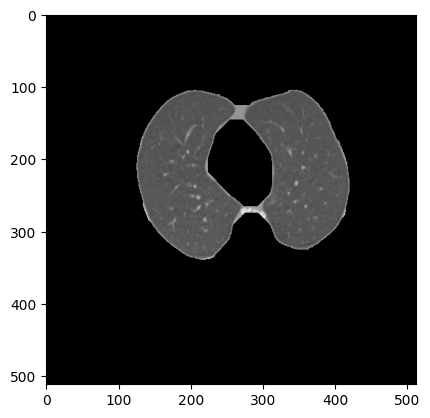

In [ ]:
plt.imshow(data_preview[100],cmap = 'gray')

In [ ]:
labels[100]

0

# **Training Models**

In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.1, stratify=labels, random_state=42,shuffle = True)

In [ ]:
trainX.shape

(180, 512, 512, 1)

In [ ]:
trainY.shape

(180,)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug_train = ImageDataGenerator(rescale= 1.0/255.,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

aug_test  = ImageDataGenerator(rescale= 1.0/255.)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (512, 512, 1), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))

# Adding Convolution
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 476288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      60,964,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,009,697 (232.73 MB)

 Trainable params: 61,009,697 (232.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import keras as k

In [ ]:
import time
NAME = "test_1-{}".format(int(time.time()))

In [ ]:
callbacks = [
#    k.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    k.callbacks.ModelCheckpoint('test_model_1.keras', save_best_only=True)]

In [ ]:
hist_1 = classifier.fit(aug_train.flow(trainX, trainY, batch_size=32), steps_per_epoch=100, epochs = 50, verbose = 1,validation_data = (testX, testY), callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  6/100 ━━━━━━━━━━━━━━━━━━━━ 25:58 17s/step - accuracy: 0.5403 - loss: 5.7715

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5390 - loss: 5.8929 - val_accuracy: 0.5000 - val_loss: 105.8324
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 888ms/step - accuracy: 0.4732 - loss: 1.3992 - val_accuracy: 0.5000 - val_loss: 7.2522
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 806ms/step - accuracy: 0.5190 - loss: 0.7088 - val_accuracy: 0.5000 - val_loss: 4.8702
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 740ms/step - accuracy: 0.4975 - loss: 0.6981 - val_accuracy: 0.3500 - val_loss: 2.1138
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 712ms/step - accuracy: 0.5164 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 2.2169
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 875ms/step - accuracy: 0.5227 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 1.8874
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 912ms/step - accuracy: 0.5127 - loss: 0.6934 - val_accuracy: 0.3000 - val_loss: 1.4356
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 959ms/step - accuracy: 0.4425 - loss: 0.6954 

In [ ]:
aug_train.fit(trainX)

In [ ]:
classifier_2 = Sequential()

# Step 1 - Convolution
classifier_2.add(Conv2D(32, (3, 3), input_shape = (512, 512, 1), activation = 'relu'))

# Step 2 - Pooling
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier_2.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
classifier_2.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a forth convolutional layer
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a forth convolutional layer
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a forth convolutional layer
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier_2.add(Flatten())

# Step 4 - Full connection
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 1, activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 510, 510, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 253, 253, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 439,361 (1.68 MB)

 Trainable params: 439,361 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import keras as k

In [ ]:
import time
NAME = "test_2-{}".format(int(time.time()))

In [ ]:
callbacks_2 = [
#    k.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    k.callbacks.ModelCheckpoint('test_model_2.keras', save_best_only=True)]

In [ ]:
hist_2 = classifier_2.fit(aug_train.flow(trainX, trainY, batch_size=32), steps_per_epoch=100, epochs = 50, verbose = 1,validation_data = (testX, testY), callbacks=callbacks_2)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 571ms/step - accuracy: 0.4762 - loss: 0.7021 - val_accuracy: 0.5000 - val_loss: 14.3909
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 593ms/step - accuracy: 0.4573 - loss: 0.6962 - val_accuracy: 0.3500 - val_loss: 1.0760
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 563ms/step - accuracy: 0.5475 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 6.1554
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 581ms/step - accuracy: 0.4945 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 4.5289
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 586ms/step - accuracy: 0.4997 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 5.1148
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 572ms/step - accuracy: 0.5240 - loss: 0.6919 - val_accuracy: 0.8000 - val_loss: 1.0285
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 620ms/step - accuracy: 0.5386 - loss: 0.6755 - val_accuracy: 0.8500 - val_loss: 6.1554
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - accuracy: 0.5510 - loss: 

Text(0.5, 0, 'Epoch')

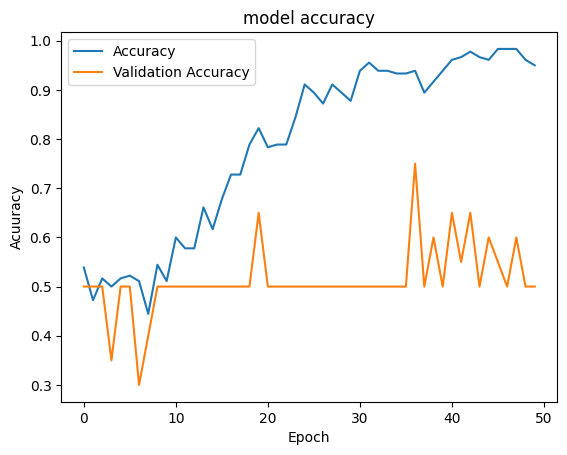

In [ ]:
# print accuracy graph
plt.plot(hist_1.history["accuracy"])
plt.plot(hist_1.history['val_accuracy'])
plt.title("model accuracy")
plt.legend(["Accuracy","Validation Accuracy"])
plt.ylabel("Acuuracy")
plt.xlabel("Epoch")

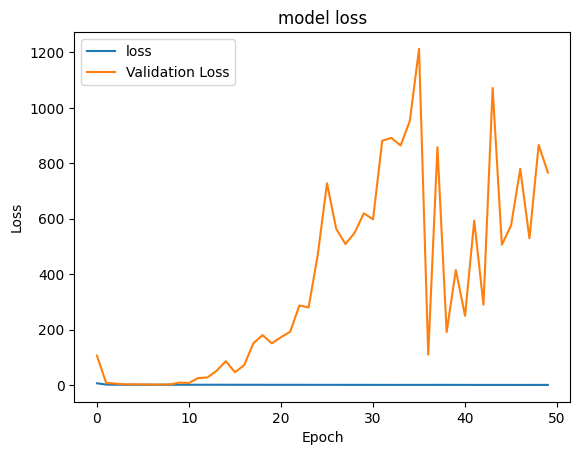

In [ ]:
# print loss graph
import matplotlib.pyplot as plt
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])

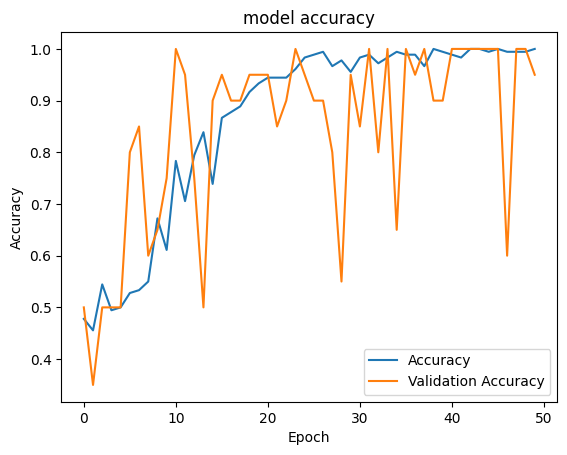

In [ ]:
# print accuracy graph
import matplotlib.pyplot as plt
plt.plot(hist_2.history["accuracy"])
plt.plot(hist_2.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])

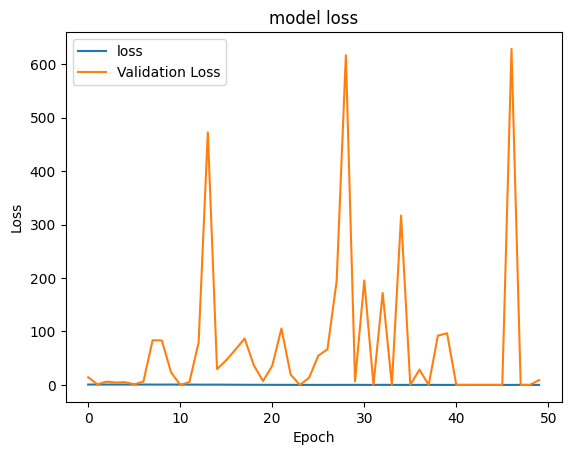

In [ ]:
# print loss graph
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])